## crvaging-020
### FEB 6 only with new HDMI cable

In [8]:
from __future__ import print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
%jsroot on
from ROOT import gROOT, gStyle, gDirectory, gPad

from array import array

import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath
import portROOT2pd

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

TARGET_OVERVOLTAGE = 3 # V
MV_PER_TRIM = -2. # mV/DAC
MV_PER_BULK = 20. # mV/DAC

topdir = os.path.dirname(os.path.abspath("__file__"))
settings_dir = os.path.join(topdir,"crvaging-020_3_settings") 

# Config tag
tag = "bulk_scan_crvaging020_3"

# Get file list using SAM
from anapytools.read_data import DataReader
reader = DataReader()
fileList = reader.get_file_list(defname='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.root')
runList = [str(run) for run in filepath.datatag[tag]["run#"]]
fileList = [file for file in fileList if any(run in file for run in runList)]
print("Files:", fileList)

DeltaBulkNorm = filepath.datatag[tag]["bulk"]

nSmooth = 1 

# One FEB
tdict = {'*':[["temperatureCMB[0][0]"], ["temperatureFEB[0]"]]}


---> Getting file list for rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.root.
Done!
Files: ['rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002119_000.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002120_000.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002121_000.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002122_000.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002123_000.root']


---> Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002119_000.root
---> Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002120_000.root
!!! spill 3, 0005 DQM = 0x1
!!! spill 5, 0008 DQM = 0x1
!!! spill 6, 0009 DQM = 0x1
!!! spill 7, 0010 DQM = 0x1
!!! spill 8, 0011 DQM = 0x1
!!! spill 9, 0012 DQM = 0x1
!!! spill 10, 0013 DQM = 0x1
!!! spill 11, 0014 DQM = 0x1
!!! spill 12, 0015 DQM = 0x1
!!! spill 13, 0016 DQM = 0x1
!!! spill 14, 0017 DQM = 0x1
!!! spill 15, 0018 DQM = 0x1
!!! spill 16, 0019 DQM = 0x1
!!! spill 17, 0020 DQM = 0x1
!!! spill 18, 0021 DQM = 0x1
!!! spill 19, 0022 DQM = 0x1
!!! spill 20, 0023 DQM = 0x1
!!! spill 21, 0024 DQM = 0x1
!!! spill 22, 0025 DQM = 0x1
!!! spill 23, 0026 DQM = 0x1
!!! spill 24, 0027 DQM = 0x1
!!! spill 25, 0028 DQM = 0x1
!!! spill 26, 0029 DQM = 0x1
!!! spill 27, 0030 DQM = 0x1
---> Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002121_000.root
!!! spill 5, 0008 DQM = 0x1
!!! spill 6, 0009 DQM = 0x1
!!! s

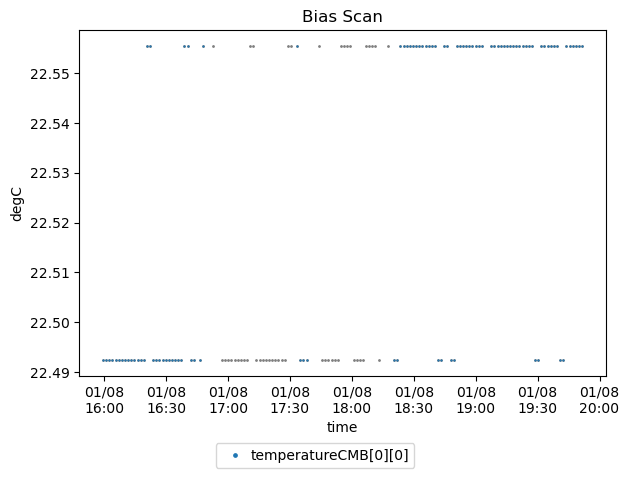

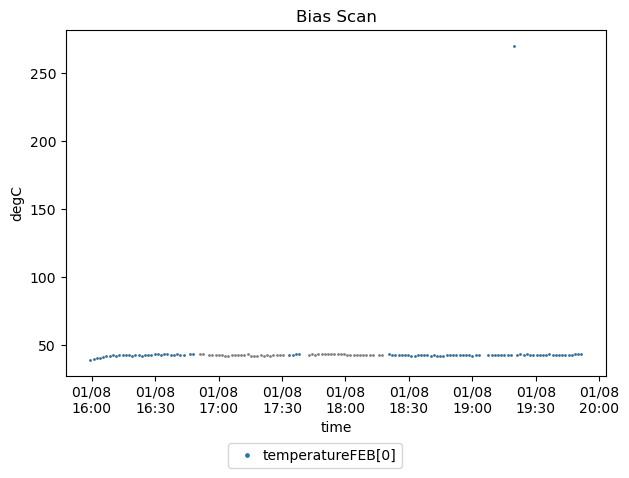

In [2]:
# tfig = utils.plot_dqm(fileList, tdict, '& 0xfffffffffffffe == 0x0', False, nSmooth, True, "Bias Scan;time;degC") 
tfig = utils.plot_dqm(fileList, tdict, ' == 0x0', False, nSmooth, True, "Bias Scan;time;degC", xroot=True) 

In [3]:
import pandas as pd
from scipy import stats
import settings_file

def PortToDFwithBulk(fileList, bulkList, xroot=False):
    df = portROOT2pd.PortToDF(fileList,{'bulkRelative':bulkList}, xroot=xroot)
    return df

def CalibrateByScan(df0, targetVover = TARGET_OVERVOLTAGE, nr = 4, nc = 4, ifDrawCorr = True):
    FEBs = df0['FEB'].unique()
    FEBs = np.sort(FEBs)

    targetBulkOver = targetVover * 1000. / MV_PER_BULK

    df_calib = pd.DataFrame()

    maintitle = "calibration"
    xtitle = "Relative Bulk Settings [DAC unit]"
    ytitle = "SPE [ADC*ns/PE]"
     
    for FEB in FEBs:
        fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(5*nc, 5*nr), sharey=True)
        plt.subplots_adjust(wspace=0)
        fig.subplots_adjust(top=0.24*nr/(0.04+0.24*nr))
        plt.suptitle(maintitle + ", FEB "+ str(FEB))
    
        for hdmi, ax in enumerate(axs.flatten()):
            ax.set_xlabel(xtitle)
            if(hdmi%4 == 0):
                ax.set_ylabel(ytitle)
            for inhdmi_chan in range(4):
                chan = hdmi*4+inhdmi_chan

                df0_ = df0.query("FEB==%i & ch==%i"%(FEB, chan)).reset_index()
                # display(df0_)
                x = df0_['bulkRelative']
                y1 = df0_['calibRaw']
                y2 = df0_['calibAdj']

                mask11 = ~np.isnan(y1) 
                mask12 = (y1!=0)
                mask1 = mask11 & mask12
                x1 = x[mask1]
                y1 = y1[mask1]

                if ifDrawCorr:
                    mask21 = ~np.isnan(y2) 
                    mask22 = (y2!=0)
                    mask2 = mask21 & mask22
                    x2 = x[mask2]
                    y2 = y2[mask2]

                bulkRelativeSetting1 = np.nan
                yref1 = np.nan
                bulkRelativeSetting2 = np.nan
                yref2 = np.nan

                # if len(x1)!=5:
                if len(x1)<3:
                    print(FEB, chan, list(df0_['bulkRelative']), list(df0_['calibRaw']), list(df0_['calibAdj']))
                    
                if len(x1)>1:
                    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1.astype(float), y1.astype(float))
                    xintercept1 = - intercept1 / slope1
                    bulkRelativeSetting1 = round(xintercept1 + targetBulkOver, 1)
                    yref1 = bulkRelativeSetting1 * slope1 + intercept1
                
                    markers1 = ax.plot(x1, y1, 'o', label='Chan: %d raw, y = %.1f + %.1f * x, (%.1f, %.1f)'%(chan, intercept1, slope1, bulkRelativeSetting1, yref1))
                    ax.plot(x1, slope1 * x1 + intercept1, '--', color = markers1[0].get_color(), linewidth=0.7)
    
                if ifDrawCorr and len(x2) > 1:
                    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2.astype(float), y2.astype(float))
                    xintercept2 = - intercept2 / slope2
                    bulkRelativeSetting2 = round(xintercept2 + targetBulkOver, 1)
                    yref2 = bulkRelativeSetting2 * slope2 + intercept2

                    markers2 = ax.plot(x2, y2, 'v', label='Chan: %d corr., y = %.1f + %.1f * x, (%.1f, %.1f)'%(chan, intercept2, slope2, bulkRelativeSetting2, yref2), color = markers1[0].get_color())
                    ax.plot(x2, slope2 * x2 + intercept2, ':', color = markers1[0].get_color(), linewidth=0.7)

                ax.legend(fontsize='small')

                df_calib_ = pd.DataFrame()
                df_calib_['FEB'] = [FEB]
                df_calib_['ch'] = [chan]
                df_calib_['bulkRelativeSettingRaw'] = [bulkRelativeSetting1]
                df_calib_['SPErefRaw'] = [yref1]
                if ifDrawCorr:
                    df_calib_['bulkRelativeSettingCorr'] = [bulkRelativeSetting2]
                    df_calib_['SPErefCorr'] = [yref2]
                
                df_calib = pd.concat([df_calib,df_calib_], ignore_index=True)

    return df_calib   

---> Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002119_000.root
---> Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002120_000.root
---> Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002121_000.root
---> Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002122_000.root
---> Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002123_000.root


,FEB,ch,bulkRelativeSettingRaw,SPErefRaw,bulkRelativeSettingCorr,SPErefCorr
0,0,0,-8.5,388.168584,-15.7,388.896128
1,0,1,-15.9,387.815298,-22.7,389.020834
2,0,2,-8.7,394.316958,-16.6,393.296404
3,0,3,-9.9,397.376210,-16.5,398.717477
4,0,4,-16.7,393.176546,-23.8,392.352349
...,...,...,...,...,...,...
59,0,59,-18.5,373.167764,-24.6,375.241482
60,0,60,-24.4,379.325992,-31.8,379.050806
61,0,61,-24.2,377.208092,-31.3,377.447337
62,0,62,-18.3,386.399750,-24.9,387.370574


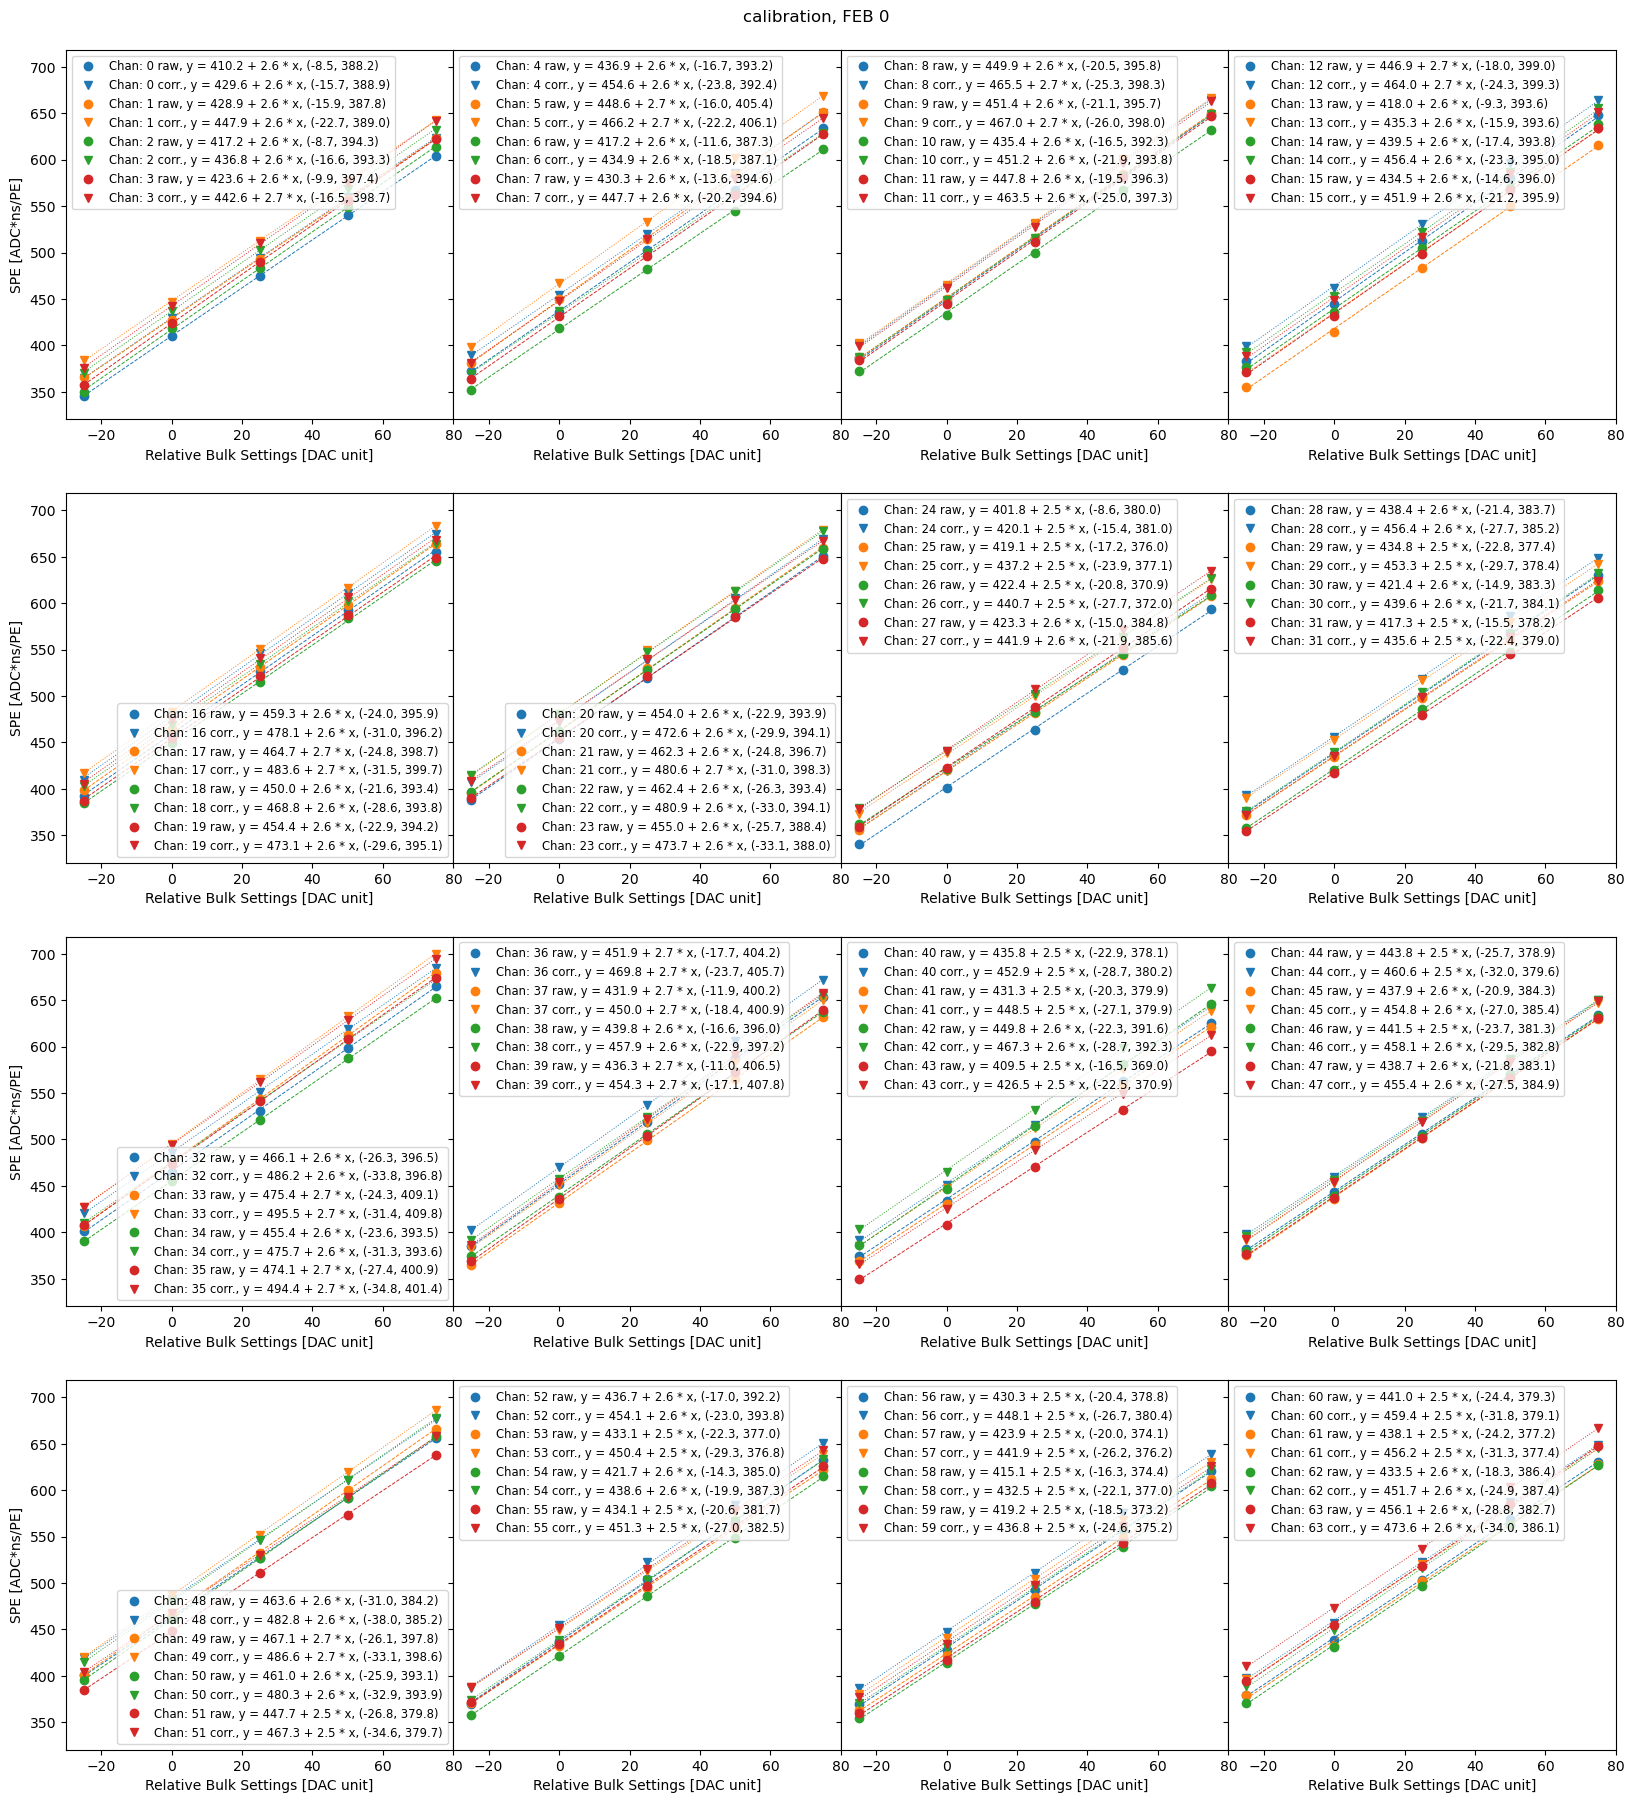

In [4]:
df = PortToDFwithBulk(fileList, filepath.datatag[tag]["bulk"], xroot=True)
df_calib = CalibrateByScan(df)
display(df_calib)

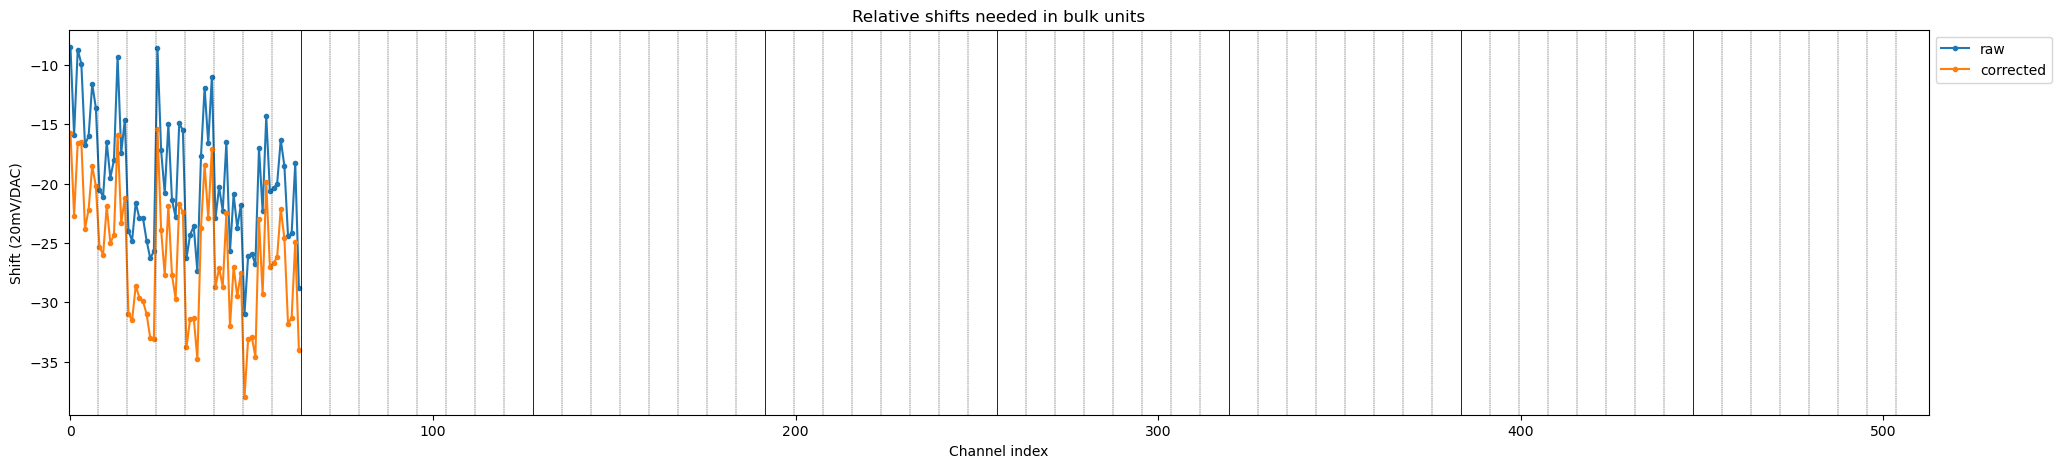

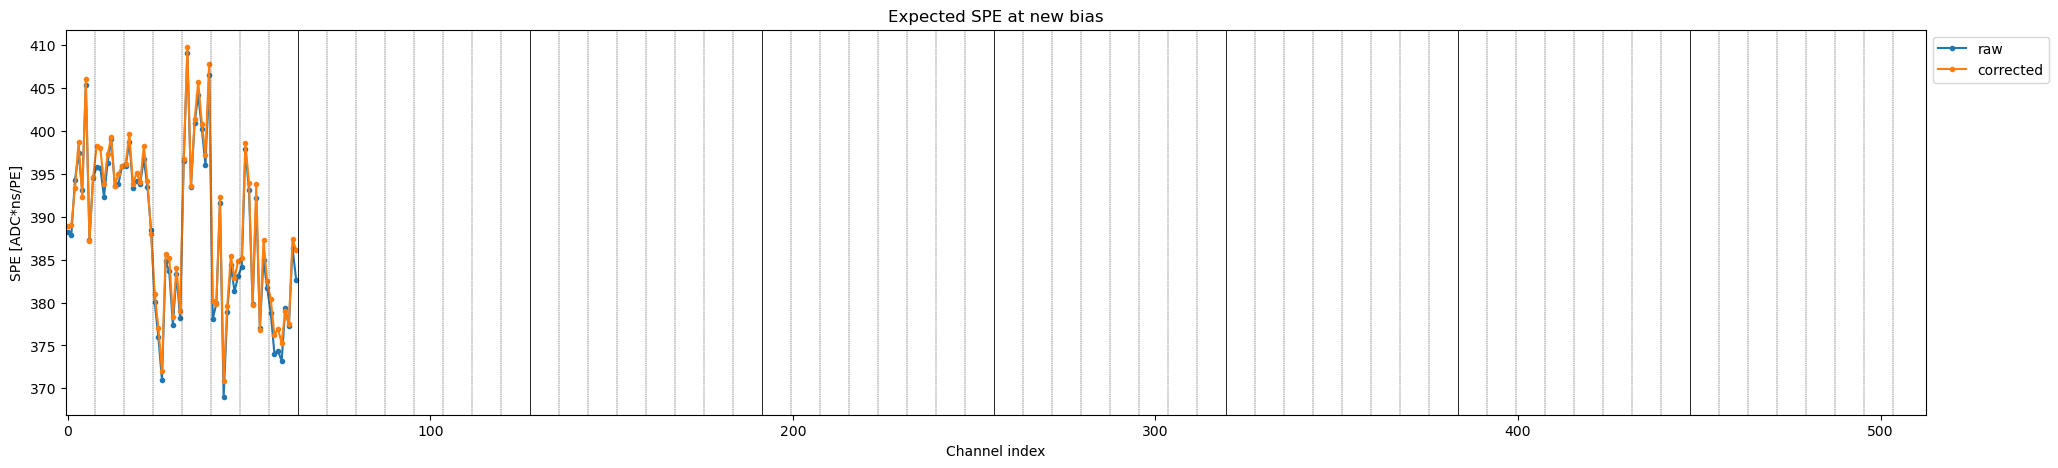

In [5]:
# check consistency
plt.figure(figsize = (24,5))
plt.plot(np.add(df_calib['FEB']*64,df_calib['ch']), df_calib['bulkRelativeSettingRaw'], '.-', label=('raw'))
plt.plot(np.add(df_calib['FEB']*64,df_calib['ch']), df_calib['bulkRelativeSettingCorr'], '.-', label=('corrected'))
plt.title("Relative shifts needed in bulk units")
plt.xlabel("Channel index")
plt.ylabel("Shift (20mV/DAC)")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iFEB in range(8):
    for iAFE in range(8):
        plt.axvline(x=8*(iFEB*8+iAFE)-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.6 if iAFE==0 else 0.3)
plt.gca().set_xlim(-0.5, 8*64+0.5)
plt.show()

plt.figure(figsize = (24,5))
plt.plot(np.add(df_calib['FEB']*64,df_calib['ch']), df_calib['SPErefRaw'], '.-', label=('raw'))
plt.plot(np.add(df_calib['FEB']*64,df_calib['ch']), df_calib['SPErefCorr'], '.-', label=('corrected'))
plt.title("Expected SPE at new bias")
plt.xlabel("Channel index")
plt.ylabel("SPE [ADC*ns/PE]")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iFEB in range(8):
    for iAFE in range(8):
        plt.axvline(x=8*(iFEB*8+iAFE)-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.6 if iAFE==0 else 0.3)
plt.gca().set_xlim(-0.5, 8*64+0.5)
plt.show()

In [6]:
def UpdateSettings(originalSettingsFiles, outputSettingsFiles, df_calib, useCorr = True, AFEmask = 0xff):
    FEBs = df_calib['FEB'].unique()
    FEBs = np.sort(FEBs)

    for FEB in FEBs:
        print("FEB%i"%FEB)
        myFilename = os.path.join(settings_dir, originalSettingsFiles[FEB])
        mySettings = settings_file.settingsFile(myFilename)
        print("before change")
        mySettings.Print()
        for chan in range(64):
            df_calib_ = df_calib.query("FEB==%i & ch==%i"%(FEB, chan)).reset_index()
            # display(df_calib_)
            if df_calib_ is not None and len(df_calib_.index)>0:
                adjustment = df_calib_['bulkRelativeSettingCorr'][0] if useCorr else df_calib_['bulkRelativeSettingRaw'][0]
                if np.isnan(adjustment):
                    mySettings.trims[chan] = 0xdead
                else:
                    mySettings.trims[chan] += int(adjustment * MV_PER_BULK / MV_PER_TRIM)
        print("no balance")
        mySettings.Print()
        mySettings.BalanceBiasTrimBulk()
        print("after change")
        mySettings.Print()
        print("\n\n\n")
        if outputSettingsFiles != None:
            mySettings.DumpToTxt(os.path.join(settings_dir, outputSettingsFiles[FEB]))
        else:
            mySettings.DumpToTxt(None, AFEmask)
    return

In [7]:
# initial_settings_files = ["Settings_crvaging-019_FEB0_sync402.txt",
#                           "Settings_crvaging-019_FEB1_sync402.txt",
#                           "Settings_crvaging-019_FEB2_sync402.txt",
#                           "Settings_crvaging-019_FEB3_sync402.txt",
#                           "Settings_crvaging-019_FEB4_sync402.txt",
#                           "Settings_crvaging-019_FEB5_sync402.txt",
#                           "Settings_crvaging-019_FEB6_sync402.txt",
#                           "Settings_crvaging-019_FEB7_sync402.txt"]

# output_settings_files = ["Settings_crvaging-020_FEB%i_sync402.txt"%i for i in range(8)]

initial_settings_files = ["Settings_crvaging-019_FEB6_sync402.txt"]
output_settings_files = ["Settings_crvaging-020_FEB6_sync402.txt"]

UpdateSettings(initial_settings_files, output_settings_files, df_calib, True) # used corrected to 20 degC

FEB0
before change
BULK| TRIM                           |GAIN
----+--------------------------------+----
A8D |833 80E 829 827 805 7B3 7DD 7D4 |384
A7F |7FB 802 7F6 7BB 834 811 81C 807 |384
A83 |7F3 819 7F7 7E5 802 804 7ED 805 |384
A7F |82A 7FA 7D0 7E0 811 81B 80F 7EA |384
A8B |83C 809 82E 813 7F5 7F1 7B5 7D6 |384
A94 |7FB 7EC 7DA 7D3 82D 7F0 810 83F |384
A8F |809 82A 7E2 824 7F1 802 7D3 80B |384
A89 |807 7FD 807 7FA 80E 816 7D9 81B |384
no balance
BULK| TRIM                           |GAIN
----+--------------------------------+----
A8D |8D0 8F1 8CF 8CC 8F3 891 896 89E |384
A7F |8F8 906 8D1 8B5 927 8B0 905 8DB |384
A83 |929 954 915 90D 92D 93A 937 950 |384
A7F |8C4 8E9 8E5 8BB 926 944 8E8 8CA |384
A8B |98E 943 967 96F 8E2 8A9 89A 881 |384
A94 |91A 8FB 8F9 8B4 96D 8FE 937 952 |384
A8F |985 975 92B 97E 8D7 927 89A 919 |384
A89 |912 903 8E4 8F0 94C 94F 8D2 96F |384
after change
BULK| TRIM                           |GAIN
----+--------------------------------+----
A7A |812 833 811 80E 835 7D